# v.bluznyukov@innopolis.university

# Task 1

## Data preparation and preprocessing

In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np
%matplotlib inline

In [ ]:
# read dataset
dataset = pd.read_csv('android_traffic.csv')

In [ ]:
dataset.head(5)

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,type
0,36,6,3,3911,0,39,33,5100,4140,39,3,benign
1,117,0,9,23514,0,128,107,26248,24358,128,11,benign
2,196,0,6,24151,0,205,214,163887,24867,205,9,benign
3,6,0,1,889,0,7,6,819,975,7,1,benign
4,6,0,1,882,0,7,6,819,968,7,1,benign


In [ ]:
# check for null values
dataset.isna().sum()

tcp_packets             0
dist_port_tcp           0
external_ips            0
vulume_bytes            0
udp_packets             0
source_app_packets      0
remote_app_packets      0
source_app_bytes        0
remote_app_bytes        0
source_app_packets.1    0
dns_query_times         0
type                    0
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

For sklearn, we need to prepare the output values to be of integer type. I chose 0 as malicious and 1 bor bening.

In [ ]:
# get features set (all columns except for 'Approved' column)
dataset['type'] = dataset['type'].replace(["benign","malicious"],[1,0])
X = dataset.drop(columns=['type'])
# get labels set
y = dataset['type']
# split into 80% - train, 20% - test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
# print the dataset
dataset.head(5)

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,type
0,36,6,3,3911,0,39,33,5100,4140,39,3,1
1,117,0,9,23514,0,128,107,26248,24358,128,11,1
2,196,0,6,24151,0,205,214,163887,24867,205,9,1
3,6,0,1,889,0,7,6,819,975,7,1,1
4,6,0,1,882,0,7,6,819,968,7,1,1


## Creating Models and Hyper-parameters tuning

* In our dataset we have only 11 features, so I have decided to use numerical max_features, bacause sqrt(11)~log(11) ~3, so it is the same number and does not provide a lot of flexibility.

* The default number of estimators is 100, as stated in the documentation, so I decided to tune on numbers that are both less and greater than 100, so 100 is kind of a mean of available parameters.

* For minimal imupity decrease, I have decided to use four values ranging from 10^(-2) till 10^(-5).


In [ ]:
from sklearn.model_selection import GridSearchCV

# Number of trees in random forest
n_estimators = [ 70, 90, 100, 130, 150]

# Number of features to consider at every split
max_features = [3, 6, 9]
# Minimum impurity decrease after which the tree will stop growning
min_impurity_decrease = np.logspace(-2, -5, num=4)

grid={
    # set possible parameters (specified in the assignment)
    "n_estimators":n_estimators, 
    "max_features":max_features,
    "min_impurity_decrease":min_impurity_decrease}

grid_base={
    # set possible parameters for base estimators (specified in the assignment)
    "n_estimators":n_estimators, 
    "base_estimator__max_features":max_features,
    "base_estimator__min_impurity_decrease":min_impurity_decrease}

### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# create a model
rfc = RandomForestClassifier(max_depth=15)
# make a grid search instance
rfc_gs = GridSearchCV(rfc,grid)
# fit the model
rfc_gs.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(max_depth=15),
             param_grid={'max_features': [3, 6, 9],
                         'min_impurity_decrease': array([1.e-02, 1.e-03, 1.e-04, 1.e-05]),
                         'n_estimators': [70, 90, 100, 130, 150]})

In [ ]:
# print the best parameters
print(rfc_gs.best_params_)

{'max_features': 3, 'min_impurity_decrease': 1e-05, 'n_estimators': 90}


### BaggingClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
# create a model
bc = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15))
# make a grid search instance
bc_gs = GridSearchCV(bc,grid_base,cv=10)
# fit the model
bc_gs.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15)),
             param_grid={'base_estimator__max_features': [3, 6, 9],
                         'base_estimator__min_impurity_decrease': array([1.e-02, 1.e-03, 1.e-04, 1.e-05]),
                         'n_estimators': [70, 90, 100, 130, 150]})

In [ ]:
# print the best parameters
print(bc_gs.best_params_)

{'base_estimator__max_features': 6, 'base_estimator__min_impurity_decrease': 1e-05, 'n_estimators': 130}


### AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# create a model
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=15))
# make a grid search instance
abc_gs = GridSearchCV(abc,grid_base,cv=10)
# fit the model
abc_gs.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=15)),
             param_grid={'base_estimator__max_features': [3, 6, 9],
                         'base_estimator__min_impurity_decrease': array([1.e-02, 1.e-03, 1.e-04, 1.e-05]),
                         'n_estimators': [70, 90, 100, 130, 150]})

In [ ]:
# print the best parameters
print(abc_gs.best_params_)

{'base_estimator__max_features': 9, 'base_estimator__min_impurity_decrease': 1e-05, 'n_estimators': 150}


## Models evaluation

* Here, I evaluated the 3 models with Accuracy and F1 scores.

In [ ]:
from sklearn import metrics
# function to evaluate
def evaluate(model, test_pred, test_labels):
    predictions = model.predict(test_pred)
    print('Model Performance')
    print("F1 score: {}".format(metrics.f1_score(test_labels, predictions, pos_label=0)))
    print("Accuracy: {}".format(metrics.accuracy_score(predictions, test_labels)))
    return

### RandomForest

In [ ]:
# get the best estimator (model with best parameters) obtained from grid search
rfc_best = rfc_gs.best_estimator_
# train the model
rfc_best.fit(X_train,y_train)
# evaluate the model
print("--RandomForestClassifier--\n")
evaluate(rfc_best, X_test,y_test)

--RandomForestClassifier--

Model Performance
F1 score: 0.8531120331950207
Accuracy: 0.887189292543021


### Bagging

In [ ]:
# get the best estimator (model with best parameters) obtained from grid search
bc_best = bc_gs.best_estimator_
# train the model
bc_best.fit(X_train,y_train)
# evaluate the model
print("--BaggingClassifier--\n")
evaluate(bc_best, X_test,y_test)

--BaggingClassifier--

Model Performance
F1 score: 0.8599508599508601
Accuracy: 0.8910133843212237


### AdaBoost

In [ ]:
# get the best estimator (model with best parameters) obtained from grid search
abc_best = abc_gs.best_estimator_
# train the model
abc_best.fit(X_train,y_train)
# evaluate the model
print("--AdaBoostClassifier--\n")
evaluate(abc_best, X_test, y_test)

--AdaBoostClassifier--

Model Performance
F1 score: 0.8423605497170573
Accuracy: 0.875717017208413


## Reflection on models and tuned parameters

We will unwrap the models one by one:

1. Bagging classifier is showing the best performance with the most F1 score of 0.89, although it is very close to RandomForest (just 1% difference), because
2. Random Forest is am example of bagging. However, it takes only a subset of randomly taken features. And indeed, the best n_estimators for Random Forest is 3 ~ sqrt(11). 
3. As for AdaBoost, we have the most estimators, probably, bacause model does sequential learning and needs to exploit all possible ways of splitting. 
Besides, AdaBoost has shown the worst results (1-2% less) with max_depth of 15.
And in my opinion, AdaBoost works better then other models with small max_depth parameter.

Therefore, with max_depth set to 15 Bagging and RandomForest take the advantage, because they are benefitting from tree depth.

This is probably because RandomForest and Bagging use multiple estimators and thus reduce the variance by averaging the trees that can be considered. Thus, in order to reduce total variance, models need to build deeper trees (increase tree complexity and its varience).

Whilst boosting takes ensemble as an iterative procedure. So if we have initially a weak classifier which we fit to data, we treat all the points equally important. This importance changes iteratively by weights in adaboost. The next classifier will not treat the points the same way: only missclassified will have higher importance. Therefore, the model creates complexity and reduces bias. Thus, AdaBoost creates complexity with sequential iteration, not tree depth and it most likely perform better then Bagging with smaller tree depth.


## 'Cross validation accuracy' plots

Here I used 5 fold cross validation to test the models on the whole dataset right now

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

I copied best parameters dictionary for convenience

In [ ]:
rfc_best_params_ = rfc_gs.best_params_
bc_best_params_ = bc_gs.best_params_
abc_best_params_ = abc_gs.best_params_

In [ ]:
# create arrays for each model to store Cross-Validation value
rfc_cv = []
bc_cv = []
abc_cv = []

for i in range(5, 26):
  # update parameter of max_depth for all of models
  rfc_best_params_['max_depth'] = i
  rfc_cva = RandomForestClassifier().set_params(**rfc_gs.best_params_)
  
  bc_best_params_['base_estimator__max_depth'] = i
  bc_cva = BaggingClassifier(base_estimator=DecisionTreeClassifier()).set_params(**bc_best_params_)

  abc_best_params_['base_estimator__max_depth'] = i
  abc_cva = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()).set_params(**abc_best_params_)
  
  # get cross validation value for the particular tree depth
  rfc_cv.append(cross_val_score(rfc_cva, X, y, scoring='accuracy', cv=10, n_jobs=1).mean())
  bc_cv.append(cross_val_score(bc_cva, X, y, scoring='accuracy', cv=10, n_jobs=1).mean())
  abc_cv.append(cross_val_score(abc_cva, X, y, scoring='accuracy', cv=10, n_jobs=1).mean())

In [ ]:
print(rfc_cv)
print(bc_cv)
print(abc_cv)

[0.7360286949174573, 0.7342485051345379, 0.7585938515533602, 0.7520949239568439, 0.7658584102430781, 0.7807739178473938, 0.7865062394384504, 0.7905898219160276, 0.7931359677629013, 0.8055009424151824, 0.8053748537631613, 0.8076691472767452, 0.8139106980371766, 0.8163351423371896, 0.8221971272585467, 0.8182451579357857, 0.8201558234758872, 0.8183733588976991, 0.8209243793058626, 0.8211747692707656, 0.819005427011569]
[0.7446971272585468, 0.7565460483556479, 0.7569399129078382, 0.7571968022877942, 0.762676784089432, 0.7747782074613285, 0.7819173274405303, 0.7900784804367607, 0.792881353178214, 0.801420609645132, 0.7998938970492656, 0.8077960483556479, 0.8071568308852204, 0.8165900818926298, 0.8179894059534643, 0.8199025087742102, 0.8183731964123229, 0.8202828870401664, 0.8200269725724685, 0.819391492265696, 0.8142931886130249]
[0.8061295983361498, 0.7945361042506175, 0.8042202326790588, 0.8058720590146885, 0.8047292993630573, 0.8068945794878462, 0.789691602755752, 0.8007750552450279, 0.8

### Plots

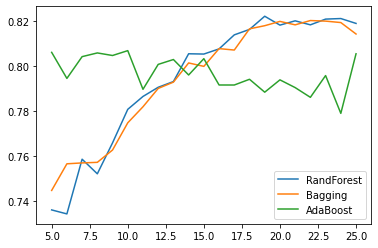

In [ ]:
from matplotlib import pyplot as plt
# plotting the respective graphs
mx_depth = [x for x in range(5,26)]
plt.plot(mx_depth,rfc_cv)
plt.plot(mx_depth,bc_cv)
plt.plot(mx_depth,abc_cv)
plt.legend(["RandForest", "Bagging", "AdaBoost"])

### Conclusion

Indeed, we can see that with smaller that Bagging and RandomForest ensemble models have deeper base learners, while AdaBoost outperforms them with shallower base learners.

# Task 2

## Preprocessing and preparation

### Startup

In [ ]:
!nvidia-smi

Thu Nov 25 12:55:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# importing necessary libraries
import os
import cv2 
import PIL
import numpy as np
from PIL import Image
import tensorflow as tf
from google.colab import drive
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# mounting a drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading images (Convert to grayscale + normalization)

In [ ]:
# function to load images from the connected drive
def load_images(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        # read the image
        img = plt.imread(os.path.join(folder,filename))
        # converting image to normalized gray scale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # if image is processed correctly
        if img is not None:
            images.append(img)
    return images
# load images into imgs
eye_imgs = load_images("drive/MyDrive/gi4e_database/images")

### Loading Coordinates data (Annotations)

In [ ]:
import pandas as pd
# now we load coordnates datasets and create columns name
headers = ["Image_name", "1","2","3","4","5","6","7","8","9", "10", "11", "12"]
# split by tab
annotations = pd.read_csv("drive/MyDrive/gi4e_database/labels/image_labels.txt", sep="\\t", header=None, names=headers, engine='python')

In [ ]:
# Lets print 5 first rows to check the dataset was read correctly
annotations.head(5)

,Image_name,1,2,3,4,5,6,7,8,9,10,11,12
0,001_01.png,490.63,338.28,471.22,338.41,452.86,341.93,401.95,342.45,383.33,339.84,362.63,338.41
1,001_02.png,493.49,332.94,479.30,333.33,455.86,340.23,404.69,340.11,391.02,334.50,364.58,335.81
2,001_03.png,495.05,333.86,477.47,332.94,458.07,339.32,407.29,339.71,389.45,333.33,368.88,334.89
3,001_04.png,493.62,334.25,472.66,332.42,456.38,338.80,405.08,340.11,385.03,334.11,367.84,336.46
4,001_05.png,495.83,333.33,470.57,331.64,457.68,338.02,406.77,339.45,382.81,333.33,369.92,334.38


In [ ]:
# separate dataset to X and Y coordinates of eye points
coordinatesX = annotations[["1","3","5","7","9","11"]].round().astype(int)
coordinatesY = annotations[["2","4","6","8","10","12"]].round().astype(int)

### Visualizing one image

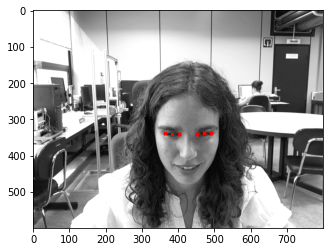

In [ ]:
image = eye_imgs[0]
plt.imshow(image, cmap="gray")
plt.scatter(coordinatesX.iloc[[0]],coordinatesY.iloc[[0]], marker="x", color="red", s=10)
plt.show()

### Cropping eye regions

Sorting coordinates of both eyes

In [ ]:
# take left eye iris-coordinates
irisLeftY = coordinatesY[["4"]].values
irisLeftX = coordinatesX[["3"]].values

# take right eye iris-coordinates
irisRightY = coordinatesY[["10"]].values
irisRightX = coordinatesX[["9"]].values

# Take coordinates of inner conrer of right eye (closer to a nose)
eyeRightInX = coordinatesX[["7"]].values
eyeRightInY = coordinatesY[["8"]].values

# Take coordinates of outer conrer of right eye 
eyeRightOutX = coordinatesX[["11"]].values
eyeRightOutY = coordinatesY[["12"]].values

# Take coordinates of outer conrer of right eye 
eyeLeftOutX = coordinatesX[["1"]].values
eyeLeftOutY = coordinatesY[["2"]].values

# Take coordinates of inner conrer of left eye (closer to a nose)
eyeLeftInX = coordinatesX[["5"]].values
eyeLeftInY = coordinatesY[["6"]].values

In [ ]:
# List to store coordinates of each iris
iris_coordinates = []

In [ ]:
# function that crops eye images
def crop(img, x1, x2, y1, y2, eyeSide, i):
    # specify the range (range is half of eye width or start_x - end_x, 
    # this range will be used to crop image in vertical direction, so the image will be symmetric)
    range = abs(x1 - x2)//2

    # define start and end x coordinates
    start_x = min(x1, x2)
    end_x = max(x1, x2)
    
    # define start and end y coordinates
    middle_y = (y1+y2)//2
    start_y = middle_y - range
    end_y = middle_y + range

    # crop and resize image
    img = cv2.resize(img[start_y:end_y,start_x:end_x], (48,48))
    
    # because we resized and cropped images, we need to fix coordinates, so they compile with new coordinate system
    # take ratio, to multiply initial coordinates
    ratioX = abs(x1 - x2)/48
    ratioY = abs(start_y - end_y)/48
    
    if eyeSide == "left":
      # update left eye coordinates
      irisLeftX[i][0] -= start_x
      irisLeftY[i][0] -= start_y
      iris_coordinates.append([irisLeftY[i][0]/ratioY,irisLeftX[i][0]/ratioX])
    else:
      # update right eye coordinates
      irisRightX[i][0] -= start_x
      irisRightY[i][0] -= start_y
      iris_coordinates.append([irisRightY[i][0]/ratioY,irisRightX[i][0]/ratioX])
    return img

In [ ]:
# main code
# create an empty list of cropped eyes (will be transformed to numpy array later)
eye_images = []
for i in range(len(eye_imgs)):
  # for each face call crop function for both eyes and append them to the list
  croppedLeft = crop(eye_imgs[i],eyeLeftInX[i][0],eyeLeftOutX[i][0],eyeLeftInY[i][0],eyeLeftOutY[i][0], "left", i)
  croppedRight = crop(eye_imgs[i],eyeRightOutX[i][0],eyeRightInX[i][0],eyeRightOutY[i][0],eyeRightInY[i][0], "right", i)

  eye_images.append(croppedLeft[..., np.newaxis])
  eye_images.append(croppedRight[..., np.newaxis])


### Creating labels

In [ ]:
# create label images
iris_pixel = []
# I have decided to highlight not just 1 pixel but 9 (1 true and 8 surrounding)
# as it was recommended in the paper shared in the assignment
# That way the model will see the target better and perform better with less epochs
for i in range(len(iris_coordinates)):
  image = np.zeros((48,48), dtype=np.float32)
  x = round(iris_coordinates[i][0])
  y = round(iris_coordinates[i][1])
  image[x,y]=1
  image[x,y+1]=1
  image[x,y-1]=1
  image[x-1,y]=1
  image[x-1,y+1]=1
  image[x-1,y-1]=1
  image[x+1,y]=1
  image[x+1,y+1]=1
  image[x+1,y-1]=1
  iris_pixel.append(image[..., np.newaxis])


### Finalizing preprocessing

In [ ]:
# Transfrom labels and predictors to np.Array
iris_pixel = np.array(iris_pixel)
eye_images = np.array(eye_images)

Min: 0.000, Max: 1.000


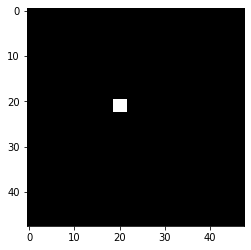

In [ ]:
# Show the label image and its pixel values range (should be between 0 and 1)
plt.imshow(iris_pixel[10][:,:,0],cmap="gray")
print('Min: %.3f, Max: %.3f' % (iris_pixel[10].min(),iris_pixel[10].max()))

Min: 0.053, Max: 0.694


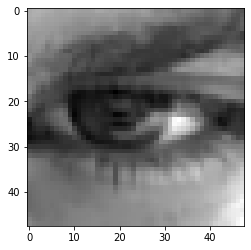

In [ ]:
# Show the train image and its pxiel values range (should be between 0 and 1)
plt.imshow(eye_images[10][:,:,0],cmap="gray")
print('Min: %.3f, Max: %.3f' % (eye_images[10].min(),eye_images[10].max()))

### Split the dataset (80% train)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(eye_images, iris_pixel, test_size=0.2, random_state= 42)

## Learning

### Startup

In [ ]:
# import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Conv2DTranspose

In [ ]:
# check that input shape is ok
image_size = eye_images.shape[1]
input_shape = (image_size, image_size, 1)
print(input_shape)

(48, 48, 1)


### Layers

I thought it would be more convenient to define firstly the best, in my opinion, model, so that you can assess its performance. 
Conserning the layers
* All layers that are contained in auxilary network have 'relu' activation (6 layers)
* All remaining base network layers have 'tanh' activation

I wanted to keep kernels reasonably small size, so that I will be able to preserve the data

In the section of **parameters hypertuning** you can see other models performances.

In [ ]:
# define the input layers
input_layer = Input(shape=input_shape)

# (48, 48, 1) => (48,48,64)
layer1 = layers.Conv2D(64, 3, padding="same", strides=1, activation = 'relu')(input_layer)
print("layer1:", layer1.shape)

# (48, 48, 64) => (24,24,128)
layer2 = layers.Conv2D(128, 3, padding="same", strides=2, activation = 'relu')(layer1)
print("layer2:", layer2.shape)

# (24,24,128) => (12,12,256)
layer3 = layers.Conv2D(256, 13, strides=1,activation = 'relu')(layer2)
print("layer3:", layer3.shape)

# (12,12,256) => (12,12,256)
layer4 = Conv2DTranspose(256, 3, strides=(1, 1), padding='same', activation = 'relu')(layer3)
print("layer4:", layer4.shape)

# (12,12,256) => (24,24,128)
layer5 = Conv2DTranspose(128, 13, activation = 'relu')(layer4)
print("layer5:", layer5.shape)

# (24,24,128) => (48,48,64)
layer6 = Conv2DTranspose(64,25,strides=(1, 1), activation = 'relu')(layer5)
print("layer6:", layer6.shape)

# (48,48,64) => (48,48,1)
output_auxilary = layers.Conv2D(1, 3,padding="same", strides=1, activation = 'relu')(layer6)

# back to base chain
# (12,12,256) => (48,48,64)
layer7 = layers.Conv2DTranspose(64, 37, strides=(1, 1), activation = 'relu')(layer3)
print("layer7:", layer7.shape)

# (48,48,64) + (48,48,64) => (48,48,128)
layer8 = layers.Concatenate(axis=3)([layer1, layer7])
print("layer8:", layer8.shape)

# (48,48,128) => (48,48,64)
layer9 = layers.Conv2D(64, 3,padding="same", strides=1, activation = 'tanh')(layer8)
print("layer9:", layer9.shape)

# (48,48,64) => (48,48,1)
output_base = layers.Conv2D(1, 3, padding="same", strides=1, activation = 'tanh')(layer9)

layer1: (None, 48, 48, 64)
layer2: (None, 24, 24, 128)
layer3: (None, 12, 12, 256)
layer4: (None, 12, 12, 256)
layer5: (None, 24, 24, 128)
layer6: (None, 48, 48, 64)
layer7: (None, 48, 48, 64)
layer8: (None, 48, 48, 128)
layer9: (None, 48, 48, 64)


In [ ]:
# creating a model and passing layers to it
model = Model(inputs=input_layer, outputs=[output_base,output_auxilary])
# you can see a summary below
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 48, 48, 64)   640         ['input_3[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 24, 24, 128)  73856       ['conv2d_12[0][0]']              
                                                                                                  
 conv2d_14 (Conv2D)             (None, 12, 12, 256)  5538048     ['conv2d_13[0][0]']              
                                                                                            

#### More visual model info

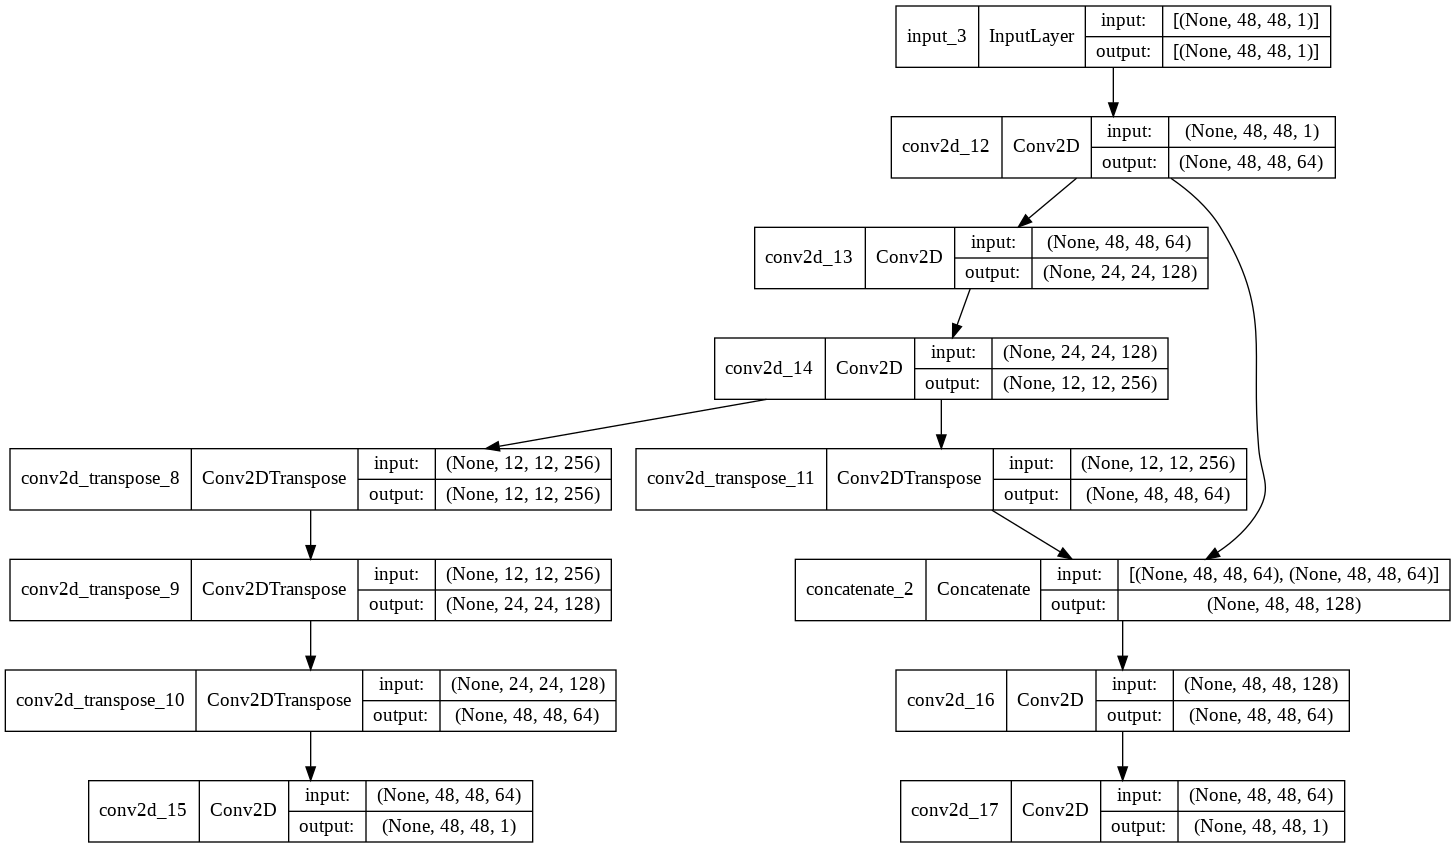

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, "info.png", show_shapes=True)

In [ ]:
# now we compile the model
model.compile(optimizer='adam',
              loss='mse')

<Figure size 432x288 with 0 Axes>

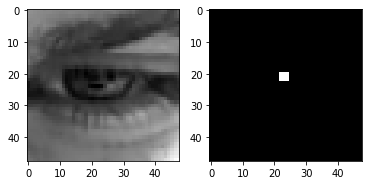

In [ ]:
# plotting random eye image and pixel image (label)
plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(eye_images[0][:,:,0], cmap="gray")
axarr[1].imshow(iris_pixel[00][:,:,0], cmap="gray")

In [ ]:
# fitting the model
model.fit(X_train, [X_train, y_train],epochs=30, batch_size=256, validation_split=0.2)

Epoch 1/30
7/7 [==============================] - 23s 3s/step - loss: 0.0649 - conv2d_17_loss: 0.0401 - conv2d_15_loss: 0.0248 - val_loss: 0.0153 - val_conv2d_17_loss: 0.0114 - val_conv2d_15_loss: 0.0039
Epoch 2/30
7/7 [==============================] - 21s 3s/step - loss: 0.0110 - conv2d_17_loss: 0.0071 - conv2d_15_loss: 0.0039 - val_loss: 0.0070 - val_conv2d_17_loss: 0.0032 - val_conv2d_15_loss: 0.0038
Epoch 3/30
7/7 [==============================] - 21s 3s/step - loss: 0.0068 - conv2d_17_loss: 0.0031 - conv2d_15_loss: 0.0037 - val_loss: 0.0054 - val_conv2d_17_loss: 0.0018 - val_conv2d_15_loss: 0.0036
Epoch 4/30
7/7 [==============================] - 21s 3s/step - loss: 0.0051 - conv2d_17_loss: 0.0015 - conv2d_15_loss: 0.0036 - val_loss: 0.0045 - val_conv2d_17_loss: 9.0242e-04 - val_conv2d_15_loss: 0.0036
Epoch 5/30
7/7 [==============================] - 21s 3s/step - loss: 0.0044 - conv2d_17_loss: 8.2126e-04 - conv2d_15_loss: 0.0036 - val_loss: 0.0041 - val_conv2d_17_loss: 5.5218e-

In [ ]:
test_scores = model.evaluate(X_test, [X_test, y_test], verbose=2)

16/16 - 3s - loss: 0.0022 - conv2d_17_loss: 8.2380e-05 - conv2d_15_loss: 0.0021 - 3s/epoch - 205ms/step


In [ ]:
# predicting on the test set
predictions = model.predict(X_test)

## Printing Test Images

<Figure size 432x288 with 0 Axes>

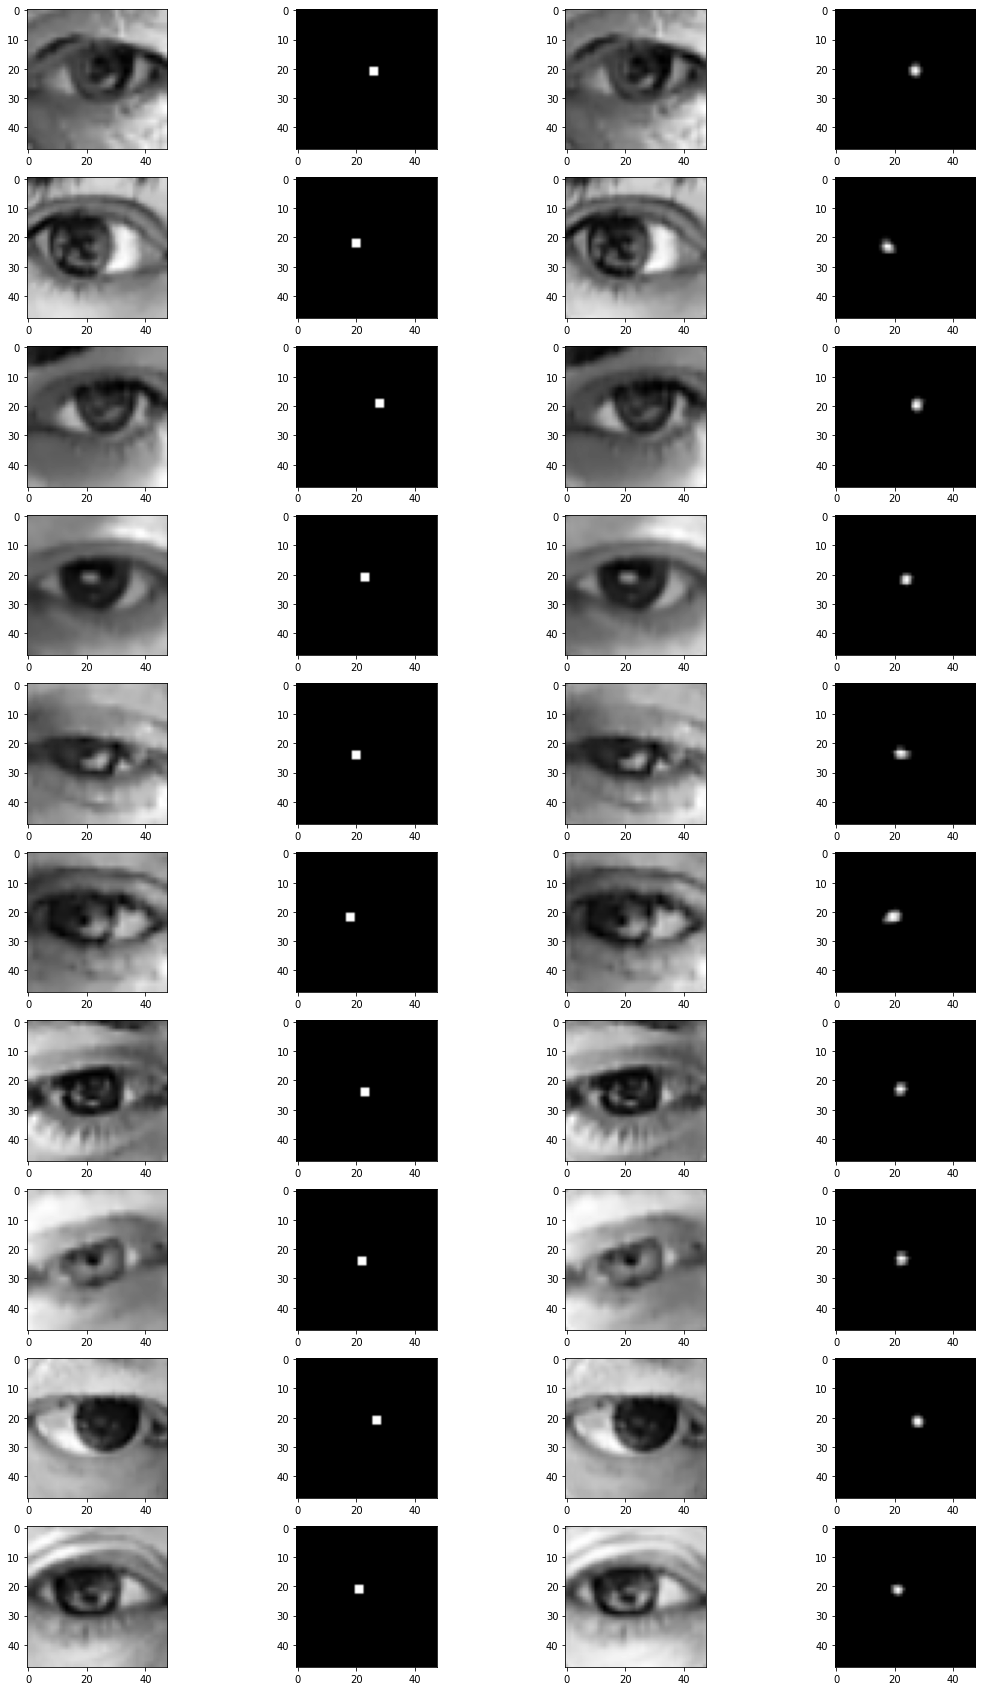

In [ ]:
plt.figure()
f, axarr = plt.subplots(10,4)
f.set_size_inches(18.5, 30.5)
for i in range (10, 20):
  # two first columns are for test input 
  axarr[i%10,0].imshow(X_test[i][:,:,0], cmap="gray")
  axarr[i%10,1].imshow(y_test[i][:,:,0], cmap="gray")
  # two last columns are for test output (model predictions)
  axarr[i%10,2].imshow(predictions[0][i][:,:,0], cmap="gray")
  axarr[i%10,3].imshow(predictions[1][i][:,:,0], cmap="gray")

## Hyperparameters tuning

Here, I will train the same model with different parameters and display the accuracy, but what is more important the resulting image(s).

In [ ]:
input_layer = Input(shape=input_shape)

def Hypertuning(optimizer, loss, activation):

  # (48, 48, 1) => (48,48,64)
  layer1 = layers.Conv2D(64, 3, padding="same", strides=1, activation = activation)(input_layer)

  # (48, 48, 64) => (24,24,128)
  layer2 = layers.Conv2D(128, 3, padding="same", strides=2, activation = activation)(layer1)

  # (24,24,128) => (12,12,256)
  layer3 = layers.Conv2D(256, 13, strides=1,activation = activation)(layer2)

  # (12,12,256) => (12,12,256)
  layer4 = Conv2DTranspose(256, 3, strides=(1, 1), padding='same', activation = activation)(layer3)

  # (12,12,256) => (24,24,128)
  layer5 = Conv2DTranspose(128, 13, activation = activation)(layer4)

  # (24,24,128) => (48,48,64)
  layer6 = Conv2DTranspose(64,25,strides=(1, 1), activation = activation)(layer5)

  # (48,48,64) => (48,48,1)
  output_auxilary = layers.Conv2D(1, 3,padding="same", strides=1, activation = activation)(layer6)

  # back to base chain
  # (12,12,256) => (48,48,64)
  layer7 = layers.Conv2DTranspose(64, 37, strides=(1, 1), activation = activation)(layer3)

  # (48,48,64) + (48,48,64) => (48,48,128)
  layer8 = layers.Concatenate(axis=3)([layer1, layer7])

  # (48,48,128) => (48,48,64)
  layer9 = layers.Conv2D(64, 3,padding="same", strides=1, activation = activation)(layer8)

  # (48,48,64) => (48,48,1)
  output_base = layers.Conv2D(1, 3, padding="same", strides=1, activation = activation)(layer9)

  #init the new model
  model_opt = Model(inputs=input_layer, outputs=[output_base,output_auxilary])

  # compiling the model
  model_opt.compile(optimizer=optimizer, loss=loss)
  model_opt.fit(X_train, [X_train, y_train],epochs=20, batch_size=256, validation_split=0.2)
  # make predictions and evaluate the model
  predictions_opt = model_opt.predict(X_test)
  test_scores = model_opt.evaluate(X_test, [X_test, y_test], verbose=2)

  print("----------")
  print("optimizer: ",optimizer, "loss: ",loss, "activation: ", activation)
  print(test_scores)


## Calculations (about 1600 lines of output, the summary is provided below)

In [ ]:
# calling function with cartesion product of parameters
optimizers = ['sgd', 'adam', 'adamax', 'rmsprop']
losses = ['mse', 'mae']
activations = ['tanh', 'relu', 'sigmoid']
for optimizer in optimizers:
  for loss in losses:
    for activation in activations:
      Hypertuning(optimizer, loss, activation)

Epoch 1/20
7/7 [==============================] - 24s 3s/step - loss: 0.0469 - conv2d_23_loss: 0.0430 - conv2d_21_loss: 0.0040 - val_loss: 0.0163 - val_conv2d_23_loss: 0.0124 - val_conv2d_21_loss: 0.0039
Epoch 2/20
7/7 [==============================] - 22s 3s/step - loss: 0.0156 - conv2d_23_loss: 0.0117 - conv2d_21_loss: 0.0039 - val_loss: 0.0131 - val_conv2d_23_loss: 0.0092 - val_conv2d_21_loss: 0.0039
Epoch 3/20
7/7 [==============================] - 22s 3s/step - loss: 0.0134 - conv2d_23_loss: 0.0096 - conv2d_21_loss: 0.0039 - val_loss: 0.0120 - val_conv2d_23_loss: 0.0082 - val_conv2d_21_loss: 0.0038
Epoch 4/20
7/7 [==============================] - 22s 3s/step - loss: 0.0124 - conv2d_23_loss: 0.0086 - conv2d_21_loss: 0.0038 - val_loss: 0.0113 - val_conv2d_23_loss: 0.0075 - val_conv2d_21_loss: 0.0038
Epoch 5/20
7/7 [==============================] - 22s 3s/step - loss: 0.0117 - conv2d_23_loss: 0.0079 - conv2d_21_loss: 0.0038 - val_loss: 0.0107 - val_conv2d_23_loss: 0.0069 - val_con

## Summary


optimizer:  **sgd** loss:  **mse** activation:  **tanh**\
[0.00789556186646223, 0.004227857105433941, 0.0036677054595202208]

optimizer:  **sgd** loss:  **mse** activation:  **relu**\
[0.011479021981358528, 0.007619753014296293, 0.003859267570078373]

optimizer:  **sgd** loss:  **mse** activation:  **sigmoid**\
[0.026427272707223892, 0.020496543496847153, 0.005930732004344463]

optimizer:  **sgd** loss:  **mae** activation:  **tanh**\
[0.05818145349621773, 0.04075249657034874, 0.017428962513804436]

optimizer:  **sgd** loss:  **mae** activation:  **relu**\
[0.03996621444821358, 0.03605976328253746, 0.003906444646418095]

optimizer:  **sgd** loss:  **mae** activation:  **sigmoid**\
[0.11695712059736252, 0.10695076733827591, 0.010006370954215527]

optimizer:  **adam** loss:  **mse** activation:  **tanh**\
[0.005849184934049845, 0.0010233147768303752, 0.004825870506465435]

optimizer:  **adam** loss:  **mse** activation:  **relu**\
[0.003928306046873331, 2.205573946412187e-05, 0.00390625]

optimizer:  **adam** loss:  **mse** activation:  **sigmoid**\
[0.012869657017290592, 0.008836744353175163, 0.004032912664115429]

optimizer:  **adam** loss:  **mae** activation:  **tanh**\
[0.15453805029392242, 0.08862190693616867, 0.06591615825891495]

optimizer:  **adam** loss:  **mae** activation:  **relu**\
[0.012096978724002838, 0.008190726861357689, 0.00390625]

optimizer:  **adam** loss:  **mae** activation:  **sigmoid**\
[0.026937197893857956, 0.022696053609251976, 0.0042411452159285545]

optimizer:  **adamax** loss:  **mse** activation:  **tanh**\
[0.005111676640808582, 0.0008988671470433474, 0.004212809260934591]

optimizer:  **adamax** loss:  **mse** activation:  **relu**\
[0.004205268807709217, 0.00029901848756708205, 0.00390625]

optimizer:  **adamax** loss:  **mse** activation:  **sigmoid**\
[0.021830225363373756, 0.01778329908847809, 0.004046925809234381]

optimizer:  **adamax** loss:  **mae** activation:  **tanh**\
[0.12022422254085541, 0.08730805665254593, 0.03291616216301918]

optimizer:  **adamax** loss:  **mae** activation:  **relu**\
[0.0073632607236504555, 0.0034570111893117428, 0.00390625]

optimizer:  **adamax** loss:  **mae** activation:  **sigmoid**\
[0.09916326403617859, 0.09384358674287796, 0.005319660995155573]

optimizer:  **rmsprop** loss:  **mse** activation:  **tanh**\
[0.08388182520866394, 0.04160115495324135, 0.042280666530132294]

optimizer:  **rmsprop** loss:  **mse** activation:  **relu**\
[0.004264304414391518, 0.00035805441439151764, 0.00390625]

optimizer:  **rmsprop** loss:  **mse** activation:  **sigmoid**\
[0.014419355429708958, 0.010513780638575554, 0.0039055722299963236]

optimizer:  **rmsprop** loss:  **mae** activation:  **tanh**\
[0.340819388628006, 0.1163027286529541, 0.22451665997505188]

optimizer:  **rmsprop** loss:  **mae** activation:  **relu**\
[0.012261697091162205, 0.00835544802248478, 0.00390625]

optimizer:  **rmsprop** loss:  **mae** activation:  **sigmoid**\
[0.1207466870546341, 0.1168331652879715, 0.003913522232323885]


Overall, the best combination is mse, adam and relu. This is the model I used, however, sometimes it produces just blank (full black) images, so I added tanh activation at the last layers of base network to introduce a bit softer activation.